# Introduction to the MIMIC-IV Database and Machine Learning with scikit-learn

**Author: Meghan R. Hutch**

**Date: January 30th, 2025**

### **About Me**

* Current Preceptor of Data Science at the University of Chicago
* Past PhD Candidate the Luo Lab 
* Graduated summer 2024 from DGP, Biomedical Informatics Concentration
* Dissertation focused on using EHR data to develop predictive models for patients with neurological illness

### **Today's lecture will be divided into two parts:**

* Introduction to working with the MIMIC-IV dataset

* Introduction to machine learning with scikit learn


We will discuss both of these in the context of a framework for conducting clinical research

**Inspired and adapted from Dr. Garrett Eickelberg's [workshop on MIMIC-III and scikit learn](https://github.com/geickelb/MIMIC-III_to_Model/tree/master)*

# Framework for Conducting Clinical Research 

---

1. Research Question Specification (hypothesis)
<br></br>
2. Cohort Specification
<br></br>
3. Data Extraction
<br></br>
4. Data Pre-processing (cleaning!)
<br></br>
5. Model Training
<br></br>
5. Model Evaluation
<br></br>

**Today, we will largely focus on steps 4-6**

### Introducing the MIMIC-IV Database

* The Medical Information Mart for Intensive Care (MIMIC)-IV is a large dataset curated to help support studies on intensive care unit (ICU) patients. 

* The MIMIC-IV dataset (since April 2024) contains structured EHR data from >360,000 patients who were admitted to Beth Israel Deaconess Medical Center in Boston, MA between 2008-2022.

* Today, we will use a previously curated [MIMIC-IV demo-dataset](https://physionet.org/content/mimic-iv-demo/2.2/) to introduce how EHR data is computationally structured and how it can be used for research purposes.

* Notably, this demo-dataset contains the data from a random subset of 100 hospitalized patients. 

* This dataset was curated for the purposes of workshops and tutorials. Thus, having appropriate CITI training is not needed. Although deidentified, access to the full dataset requires a physionet account and [CITI training](https://physionet.org/about/citi-course/).

# Data Extraction

- The full demo dataset has been downloaded to the classroom's quest allocation.
- The data used for this lecture are available in the relevant [GitHub Repo](https://github.com/meghutch/mimic-ml-demo)
- We will further load this data into our notebook


### Load in MIMIC-IV Demo

First, we will import some basic packages

In [1]:
# import our packages
import os

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# set our working directory - this notebook assume you are in the classroom Quest folder ('/projects/e30766/mimic-iv-demo/2.2') where the MIMIC-IV demo dataset is located
#os.chdir('/projects/e30766/mimic-iv-demo/2.2')

In [3]:
# set relative working directory assuming you downloaded this lecture from GitHub:
os.chdir('data/mimic-iv-clinical-database-demo-2.2')

In [4]:
# make sure you are in the working directory: 
os.getcwd()

'C:\\Users\\meghan_hutch\\Documents\\Projects\\mimic-ml-demo\\data\\mimic-iv-clinical-database-demo-2.2'

Next, we will load the list of subject identifiers (`subject_id`) for the demo cohort

In [5]:
# load data
subject_id = pd.read_csv('demo_subject_id.csv')

In [6]:
# view the first 5 rows of data
subject_id.head(5)

,subject_id
0,10000032
1,10001217
2,10001725
3,10002428
4,10002495


In [7]:
# check how many unique subjects
subject_id['subject_id'].nunique()

100

**Overview of MIMIC-IV Tables**

For this demo, we will explore data found in the following two MIMIC-IV modules:


### [Hosp](https://mimic.mit.edu/docs/iv/modules/hosp/)

> "The Hosp module provides all data acquired from the hospital wide electronic health record. Information covered includes patient and admission information, laboratory measurements, microbiology, medication administration, and billed diagnoses."

### [ICU](https://mimic.mit.edu/docs/iv/modules/icu/)

> "The ICU module contains information collected from the clinical information system used within the ICU. Documented data includes intravenous administrations, ventilator settings, and other charted items."

**Notes:**

* The [GitHub repo](https://github.com/meghutch/mimic-ml-demo/tree/main) for this lecture only contains the data used for this workshop (due to GitHub storage limits). However, all data tables within the `hosp` and `icu` modules have been downloaded to Quest: `/projects/e30766/mimic-iv-demo/2.2`

* The full MIMIC-IV dataset also contains additional modules for data from emergency department (ED), chest X-rays (CXR), and clinical notes (Note)

Next, let's look at the `patient` table found within the `hosp` module.

The `patient` table contains each patient's unique `subject_id` and some simple demographic data

In [8]:
patients = pd.read_csv('hosp/patients.csv.gz')

In [9]:
# review the first 5 rows
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


What do these columns mean? 

For this, we can review the data dictionary: https://mimic.mit.edu/docs/iv/modules/hosp/patients/

In [10]:
# review the first 5 rows
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


Important note about MIMIC's pre-processing of [dates](https://mimic.mit.edu/docs/iv/modules/hosp/patients/#anchor_age-anchor_year-anchor_year_group):

* Dates are randomly shifted consistently for all patients

* `anchor_year` - shifted year for the patient

* `anchor_year_group` -  is a range of years - the patient’s `anchor_year` actually occurred during this range

* `anchor_age` - the patient’s age in the `anchor_year` (year of admission). 

**Examples**: 

A patient has an `anchor_year` of 2153, `anchor_year_group` of 2008 - 2010, and an `anchor_age` of 60.

* The year 2153 for the patient corresponds to 2008, 2009, or 2010.

* The patient was 60 in the shifted year of 2153, i.e. they were 60 in 2008, 2009, or 2010.

* A patient admission in 2154 will occur in 2009-2011, an admission in 2155 will occur in 2010-2012, and so on.

* Note: Due to HIPAA patient confidentiality concerns, if a patient’s `anchor_age` is over 89 in the `anchor_year` then their `anchor_age` is set to 91, regardless of how old they actually were.

In [11]:
# review the first 5 rows
patients.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10014729,F,21,2125,2011 - 2013,NaN
1,10003400,F,72,2134,2011 - 2013,2137-09-02
2,10002428,F,80,2155,2011 - 2013,NaN
3,10032725,F,38,2143,2011 - 2013,2143-03-30
4,10027445,F,48,2142,2011 - 2013,2146-02-09


In [12]:
# review the number of unique values in each dataset
patients['subject_id'].nunique()

100

In [13]:
len(patients)

100

**Let's load in several additional tables from MIMIC:**

Here, we will load a few of the tables we will use to demonstate the workflow of aquiring, pre-processing, and analyzing data from the MIMIC database.

In [14]:
# load several tables from the hosp module
admissions = pd.read_csv('hosp/admissions.csv.gz') # info about hospital stay
omr = pd.read_csv('hosp/omr.csv.gz') # misc info from EHR
labevents = pd.read_csv('hosp/labevents.csv.gz') # laboratory measurements
d_labitems = pd.read_csv('hosp/d_labitems.csv.gz') # dictionary of laboratory values
diagnoses = pd.read_csv('hosp/diagnoses_icd.csv.gz') # icd codes assigned to patient for billing
d_icd_diagnoses = pd.read_csv('hosp/d_icd_diagnoses.csv.gz') # dictionary of icd variable

# load several tables from the icu module
chartevents = pd.read_csv('icu/chartevents.csv.gz') # info charted during patient's hospital stay
d_items = pd.read_csv('icu/d_items.csv.gz') # dictionary of ICU event variables  

### omr table

> "The Online Medical Record (OMR) table contains miscellaneous information from the EHR."

[omr documentation](https://mimic.mit.edu/docs/iv/modules/hosp/omr) of columns:

* `chartdate` - the date on which the observation was recorded
* `seq_num`- a monotonically increasing integer which uniquely distinguishes results of the same type recorded on the same day. For example, if two blood pressure measurements occur on the same day, seq_num orders them chronologically.
* `result_name` - human interpretable description of the observation
* `result_value` - the value associated with the observation

In [15]:
# review the first 5 rows
omr.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136


In [16]:
# review unique result_names (observations)
# here we can see the unique variables/measurements contained in this table
omr[['result_name']].drop_duplicates()

,result_name
0,Height (Inches)
1,Weight (Lbs)
8,BMI (kg/m2)
14,Blood Pressure
2206,Blood Pressure Standing (1 min)
2208,Blood Pressure Sitting
2222,Blood Pressure Lying
2590,Blood Pressure Standing (3 mins)


# Data Pre-processing (Data Cleaning)

### What does it mean to clean data?

Simply, data cleaning is the act of preparing data for analysis. In a clinical context, we also want to make sure that the data we are using is clinically relevant and accurate, especially in regard to the specific clinical question or problem we are trying to solve.


### How do we "clean" data:

* Ensure data are formatted into the right data types (numeric, character, date, etc)

* Review summary statistics (how many observations, how many patients have each observation, mean/median/sd/variance of values, proportion of missing data)

* Review the distribution of data

* Are there possible data entry problems or unit conversions needed?

* How should we handle missing data?

* Should patients have repeated measurements (e.g. multiple white blood cell counts on the same day)? If so, how should we handle repeated observations?

> “Data science, he says, involves multiple “very small decisions” — data cleaning and filtering steps, for instance, which are crucially important, but difficult to document. And journal page limits preclude exposition. But by blending code, data and text in a single document, researchers can show just how their results were generated.” - Ben Marwick; [Perkel, JM](https://www.nature.com/articles/d41586-022-00563-z)

### Example of Data Cleaning (Height)

**Let's focus on the variables `Height` and `Weight`**

We will filter the `omr` table to only contains results for height and weight. During data cleaning, each variable will be saved in its own dataframe for ease of pre-processing

In [17]:
# create separate dataframes for each variable
height = omr[omr['result_name']=="Height (Inches)"].copy() # copy tells Python to keep our new df 'height' independent from the original df 'omr' it was sourced from

weight = omr[omr['result_name']=="Weight (Lbs)"].copy()

**Examine Height (inches)**

In [18]:
height.head()

,subject_id,chartdate,seq_num,result_name,result_value
0,10011398,2146-12-01,1,Height (Inches),63
13,10011398,2147-01-22,1,Height (Inches),61.5
20,10014729,2125-02-22,1,Height (Inches),65
21,10014729,2125-04-05,1,Height (Inches),66
22,10014729,2126-01-24,1,Height (Inches),66


Let's check the number of observations

In [19]:
print('Number of height measurements:', len(height))
print('Number of unique patients with height measurements:', height['subject_id'].nunique())

Number of height measurements: 378
Number of unique patients with height measurements: 61


It looks like `result_value` is a continuous variable. Let's make sure that Python also has recognized it as such.

In [20]:
# check variable data types
height.dtypes

subject_id       int64
chartdate       object
seq_num          int64
result_name     object
result_value    object
dtype: object

It looks like Python read `result_value` as a object (or character) variable. Let's convert to numeric. This is an important step to make sure any downstream functions (calculating the mean or median, plotting the distribution, etc) work correctly.

In [21]:
height['result_value'] = pd.to_numeric(height['result_value'])

In [22]:
# check variable data types again to make sure our transformation and code worked
# float64 indicates a continuous variable, so this looks good!
height.dtypes

subject_id        int64
chartdate        object
seq_num           int64
result_name      object
result_value    float64
dtype: object

### Using Summary Statistics and Visualization to help Evaluate Data

Next, let's calculate summary statistics to get a better sense of our variable

In [23]:
height['result_value'].describe()

count    378.000000
mean      67.105952
std        5.117295
min        5.000000
25%       63.500000
50%       67.000000
75%       71.000000
max       73.000000
Name: result_value, dtype: float64

**Visualize distribution of values**

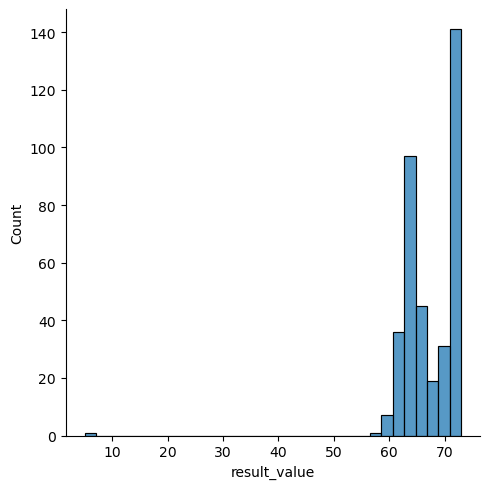

In [24]:
sns.displot(height['result_value'])

**Potential red flag:** Is there really a patient who might be 5 inches tall? This is a clear case I'd like to investigate more. Perhaps this is a data entry issue or a newborn?

**Further explore data to check for inconsistencies**

First, we can sort the height values from lowest to highest in order to retrieve the `subject_id` of the patient with a height of 5 inches

I can also see if there are any other patients with unusually low heights

In [25]:
height.sort_values(['result_value'])

,subject_id,chartdate,seq_num,result_name,result_value
1844,10012853,2175-04-05,1,Height (Inches),5.0
2883,10002428,2154-10-18,1,Height (Inches),58.0
2884,10002428,2158-09-13,1,Height (Inches),59.0
2885,10002428,2155-08-12,1,Height (Inches),59.0
1262,10037928,2175-12-06,1,Height (Inches),60.0
...,...,...,...,...,...
776,10014354,2150-05-01,1,Height (Inches),73.0
775,10014354,2147-06-04,1,Height (Inches),73.0
777,10014354,2148-12-07,1,Height (Inches),73.0
2951,10004733,2175-12-10,1,Height (Inches),73.0


Let's see if this patient has other recorded height measurements

In [26]:
# let's see if this patient has other recorded height measurements
height[height['subject_id']==10012853].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value
1844,10012853,2175-04-05,1,Height (Inches),5.0
1846,10012853,2176-06-07,1,Height (Inches),64.0
1847,10012853,2177-01-05,1,Height (Inches),64.0
1845,10012853,2178-11-04,1,Height (Inches),64.0


**Investigate patients with multiple observations**

For each unique patient, we will calculate the standard deviation of the patient's height measurements

*Note*: `ddof = 0` indicates that std for patients with one measurement will be displayed as 0 rather than NaN

In [27]:
height['std'] = height.groupby('subject_id')['result_value'].transform(np.std, ddof=0)

C:\Users\meghan_hutch\AppData\Local\Temp\ipykernel_34512\368505687.py:1: FutureWarning: The provided callable <function std at 0x0000023B82357600> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  height['std'] = height.groupby('subject_id')['result_value'].transform(np.std, ddof=0)


In [28]:
height.sort_values('std', ascending = False)[['subject_id', 'std']].drop_duplicates().head(10)

,subject_id,std
1845,10012853,25.547749
1096,10005909,2.724312
461,10019917,1.000000
2719,10022880,0.942809
299,10001725,0.862706
13,10011398,0.750000
1263,10037928,0.745356
2733,10004457,0.731247
2885,10002428,0.707107
534,10005348,0.596212


We can clearly see the one 'concerning' patient has a much higher standard deviation of their height measurements compared to other patients.

Let's take a look at patient with the second highest standard deviation 

In [29]:
height[height['subject_id']==10005909].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value,std
1094,10005909,2144-10-29,1,Height (Inches),65.0,2.724312
1102,10005909,2144-11-15,1,Height (Inches),72.5,2.724312
1095,10005909,2144-12-10,1,Height (Inches),70.0,2.724312
1096,10005909,2145-01-03,1,Height (Inches),70.0,2.724312


**For patients with multiple observations, let's calculate the median**

In [30]:
# create a new variable with the median height value for each patient
height['result_value_median'] = height.groupby('subject_id')['result_value'].transform('median')

**Save the new dataset**

This next step ensures that we will now only have one unique row per patient

In [31]:
# assuming we don't need to link by date
height_clean = height[['subject_id', 'result_name', 'result_value_median']].drop_duplicates()

Let's review the distribution again

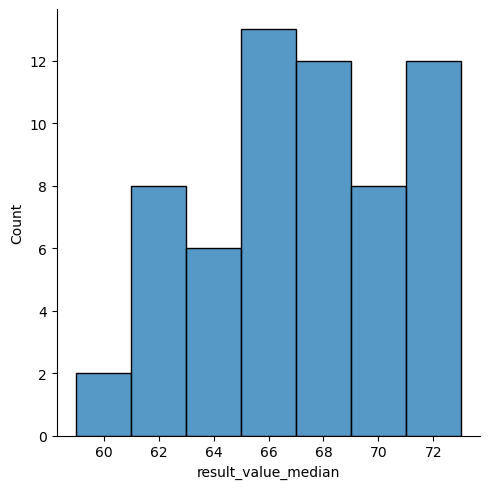

In [32]:
sns.displot(height_clean['result_value_median'])

In [33]:
# the number of unique subject_id should match our original height dataframe
height_clean['subject_id'].nunique() == height['subject_id'].nunique()

# important to check to make sure we didn't accidently lose information

True

### Another Example of Data Cleaning (Weight)

In [34]:
weight.head()

,subject_id,chartdate,seq_num,result_name,result_value
1,10011398,2147-01-22,1,Weight (Lbs),127
2,10011398,2146-12-01,1,Weight (Lbs),135
3,10011398,2147-07-24,1,Weight (Lbs),136
4,10011398,2147-03-26,1,Weight (Lbs),136
5,10011398,2147-06-25,1,Weight (Lbs),139


**Review variable types**

It looks like `result_value` is a continuous variable. Let's make sure that Python also has recognized it as such.

In [35]:
# check variable data types
weight.dtypes

subject_id       int64
chartdate       object
seq_num          int64
result_name     object
result_value    object
dtype: object

In [36]:
weight['result_value'] = pd.to_numeric(weight['result_value'])

In [37]:
# check variable data types
weight.dtypes

subject_id        int64
chartdate        object
seq_num           int64
result_name      object
result_value    float64
dtype: object

In [38]:
weight['result_value'].describe()

count    941.000000
mean     173.202763
std       44.009522
min       88.000000
25%      147.300000
50%      169.310000
75%      185.000000
max      296.000000
Name: result_value, dtype: float64

**Distribution of weight values**

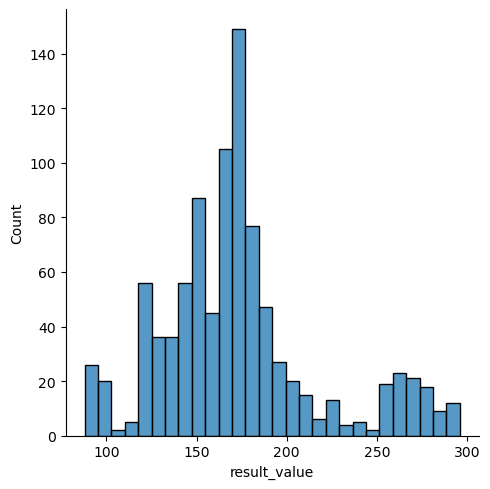

In [39]:
sns.displot(weight['result_value'])

**Investigate the standard deviation in the measurements of patients with multiple observations**

In [40]:
weight['std'] = weight.groupby('subject_id')['result_value'].transform(np.std, ddof=0)# ddof = 0 indicates that std for patients with one measurement will be displayed as 0 rather than NaN

C:\Users\meghan_hutch\AppData\Local\Temp\ipykernel_34512\2567597466.py:1: FutureWarning: The provided callable <function std at 0x0000023B82357600> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  weight['std'] = weight.groupby('subject_id')['result_value'].transform(np.std, ddof=0)# ddof = 0 indicates that std for patients with one measurement will be displayed as 0 rather than NaN


In [41]:
weight.sort_values('std', ascending = False)[['subject_id', 'std']].drop_duplicates().head(5)

,subject_id,std
177,10019385,58.385000
644,10021487,22.758934
2122,10019003,19.732249
1176,10039708,19.442869
2705,10040025,16.104849


In [42]:
weight[weight['subject_id']==10019385].sort_values('chartdate') # did this patient lose > 110 pounds in < 1 month?

,subject_id,chartdate,seq_num,result_name,result_value,std
179,10019385,2180-02-15,1,Weight (Lbs),214.07,58.385
177,10019385,2180-03-04,1,Weight (Lbs),97.30,58.385


**Potential Unit Issue?**

If 1 kg = 2.20462 lbs:

97.30 kg * 2.20462 = 214.5 lbs (this is almost exactly what was measured in the first observation!)

It's also possible that the patient was actually 97.3 lbs and the 214.07 was mistakenly measured in kgs (~471 pounds) - this seems a bit less likely, due to our distribution (max value is 296) - but may still be possible.

In [43]:
weight['result_value'].describe()

count    941.000000
mean     173.202763
std       44.009522
min       88.000000
25%      147.300000
50%      169.310000
75%      185.000000
max      296.000000
Name: result_value, dtype: float64

Review a second patient with high standard deviation

In [44]:
weight[weight['subject_id']==10021487].sort_values('chartdate')

,subject_id,chartdate,seq_num,result_name,result_value,std
644,10021487,2117-01-14,1,Weight (Lbs),264.0,22.758934
643,10021487,2117-01-19,1,Weight (Lbs),254.0,22.758934
641,10021487,2117-02-10,1,Weight (Lbs),227.0,22.758934
638,10021487,2117-05-05,1,Weight (Lbs),204.0,22.758934
635,10021487,2117-06-16,1,Weight (Lbs),193.0,22.758934
656,10021487,2117-07-07,1,Weight (Lbs),196.6,22.758934
636,10021487,2117-08-18,1,Weight (Lbs),199.0,22.758934
637,10021487,2117-08-18,2,Weight (Lbs),199.0,22.758934
639,10021487,2117-09-09,1,Weight (Lbs),208.0,22.758934
657,10021487,2117-12-03,1,Weight (Lbs),210.1,22.758934


### Notes:

In the first case, my intuition is that the discrepancy in weight measurements is due to a unit conversions issue

In the second case, the patient has many weight measurements over the a 1.5 year period. The measurements themselves don't vary too widely. 

**Important Notes:** 

* The best way to handle these types of inconsistencies will largely depend on the exact variable, question of interest, and domain knowledge. 
<br> </br>
* Seek consultation from mentors and domain experts! 
<br> </br>
* In this case, I'm not considering the date or specific admission. Some patients have multiple admissions. 
<br> </br>
* Additionally, depending how old a patient is, or even gender, height or weight may be expected to change more dramatically overtime. In those cases, we might want to consider these demographic factors before just taking the median.

#### Missing Data

This topic could be it's own class. 

Rule of thumb: Talk to your domain experts/collaborators!

Some common ways to handle missing data:

* Remove those patients - need to make sure you have a valid reason for this!
* Impute mean or median
* Forward or backward filling of the first or most recent value 
* multiple imputation by chained equations (MICE) 

In the above cases, I used the median to impute. This may or may not be the best method depending on your use cases. Here, I wanted to keep it simple!

### Evaluating Unit Conversions

Another clinical variable that often needs cleaning are laboratory test measurements.

In MIMIC we can use the `labevents` and `d_labitems` tables to work with laboratory data. 

Importantly, `d_labitems` links to the `labevents` table. 

The `d_labitems` provides the definitions (or names) or the specific labs via the `itemid`.

In [45]:
# let's first look at the labevents table
labevents.head()

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN


In [46]:
# let's first look at the d_labitems table
d_labitems.head()

,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas


### Example Data Cleaning (Laboratory Tests)

1. We can merge `d_labitems` and `labevents` by shared identifiers (we'll review this in the next section on merging tables)

2. We can search for specific labs of interest via the `label` column

3. We can also filter with specific `itemid` numbers if we know which correspond to labs of interest

First, let's try and see whether we can find the `itemid` for potassium

In [47]:
d_labitems[d_labitems['label'].str.contains('potassium', case = False, na=False)]

,itemid,label,fluid,category
20,52452,"Potassium, Whole Blood",Blood,Blood Gas
39,50822,"Potassium, Whole Blood",Blood,Blood Gas
56,52046,"Potassium, Urine",Urine,Blood Gas
59,50833,Potassium,Other Body Fluid,Blood Gas
218,52610,Potassium,Blood,Chemistry
308,50971,Potassium,Blood,Chemistry
490,51064,"Potassium, Stool",Stool,Chemistry
520,51097,"Potassium, Urine",Urine,Chemistry
636,50847,"Potassium, Ascites",Ascites,Chemistry
684,51057,"Potassium, Pleural",Pleural,Chemistry


In [48]:
potassium = labevents[labevents['itemid']==50971]
potassium.nunique()

labevent_id          3022
subject_id            100
hadm_id               250
specimen_id          3022
itemid                  1
order_provider_id      93
charttime            3018
storetime            3021
value                  31
valuenum               51
valueuom                1
ref_range_lower         2
ref_range_upper         2
flag                    1
priority                2
comments               11
dtype: int64

In [49]:
potassium

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
21,172088,10014354,29600294.0,43195817,50971,NaN,2148-08-16 00:00:00,2148-08-16 01:47:00,5.2,5.2,mEq/L,3.3,5.1,abnormal,ROUTINE,NaN
81,172597,10014354,26486158.0,78241917,50971,NaN,2148-08-24 00:00:00,2148-08-24 01:34:00,4.4,4.4,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
109,408883,10035631,29462354.0,7964528,50971,NaN,2112-09-24 00:00:00,2112-09-24 01:17:00,4.2,4.2,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
155,336034,10029484,NaN,79775396,50971,NaN,2160-11-08 00:00:00,2160-11-08 00:33:00,4.5,4.5,mEq/L,3.3,5.1,NaN,STAT,NaN
173,411486,10035631,20385771.0,88649212,50971,NaN,2112-12-16 00:00:00,2112-12-16 02:03:00,3.8,3.8,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107595,418158,10035631,29276678.0,2091476,50971,NaN,2116-03-05 18:59:00,2116-03-05 19:39:00,3.7,3.7,mEq/L,3.3,5.1,NaN,STAT,NaN
107605,408782,10035631,29462354.0,48589180,50971,NaN,2112-09-21 22:59:00,2112-09-22 01:11:00,3.8,3.8,mEq/L,3.3,5.1,NaN,ROUTINE,NaN
107638,255520,10021487,28998349.0,52829826,50971,NaN,2116-12-22 04:59:00,2116-12-22 06:08:00,4.2,4.2,mEq/L,3.3,5.1,NaN,STAT,NaN
107663,473242,10040025,27876215.0,29795328,50971,NaN,2147-11-14 04:59:00,2147-11-14 06:18:00,3.9,3.9,mEq/L,3.3,5.1,NaN,STAT,NaN


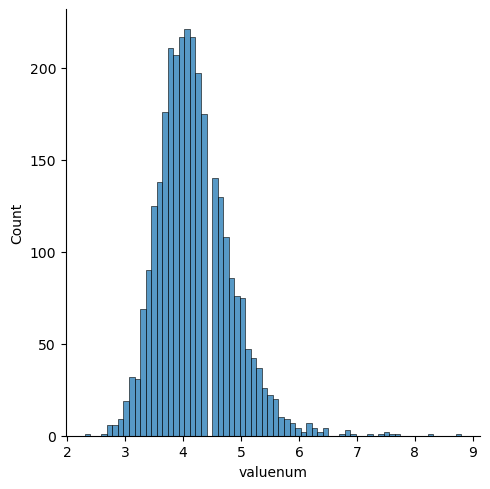

In [50]:
sns.displot(potassium['valuenum'])

In [51]:
# let's check the distinct units of potassium
potassium[['valueuom']].value_counts() # only unit is Milliequivalents per liter 

valueuom
mEq/L       3022
Name: count, dtype: int64

**Let's evaluate another lab test, one which has more than one unit specification**

In [52]:
d_labitems[d_labitems['itemid']==51249]

,itemid,label,fluid,category
979,51249,MCHC,Blood,Hematology


In [53]:
# *Mean Corpuscular Hemoglobin Concentration
MCHC = labevents[(labevents['itemid']==51249)]
MCHC['valueuom'].value_counts()

valueuom
g/dL    1555
%       1205
Name: count, dtype: int64

In [54]:
lab_perc = MCHC[MCHC['valueuom']=='%']

In [55]:
lab_gdl = MCHC[MCHC['valueuom']=='g/dL']

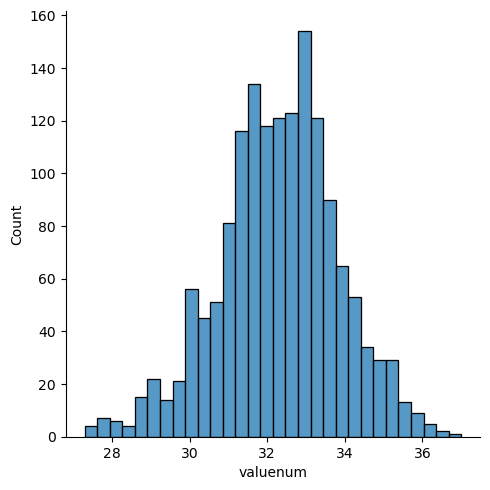

In [56]:
sns.displot(lab_gdl['valuenum'])

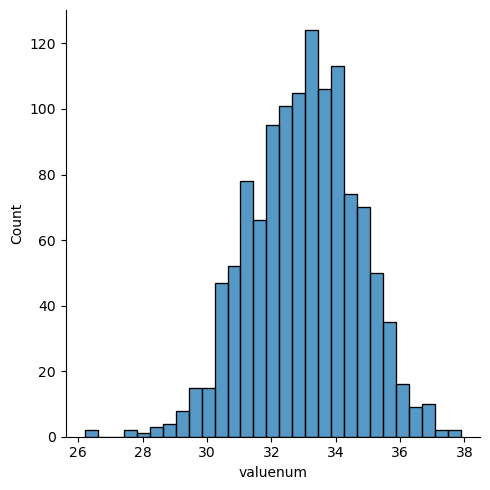

In [57]:
sns.displot(lab_perc['valuenum'])

### Cleaning EHR Data - Common pitfalls :

- missing data
- inaccurate data
- data inconsistencies
- misunderstanding data and where/how it was generated

## Working with large EHR datasets

#### Merging tables 

Tables can be merged (e.g. linked) together through shared identifiers. The MIMIC official [documentation](https://mimic.mit.edu/docs/iv/) is a great reference for learning more about the associations between tables

First, let's take a look at the diagnosis data that we have for patients

In [58]:
diagnoses.head()

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10035185,22580999,3,4139,9
1,10035185,22580999,10,V707,9
2,10035185,22580999,1,41401,9
3,10035185,22580999,9,3899,9
4,10035185,22580999,11,V8532,9


In order to obtain more detailed information about each ICD code, we can use the the `d_icd_diagnoses` which contains a longer description of each icd code.

In [59]:
d_icd_diagnoses

,icd_code,icd_version,long_title
0,0090,9,"Infectious colitis, enteritis, and gastroenter..."
1,01160,9,"Tuberculous pneumonia [any form], unspecified"
2,01186,9,"Other specified pulmonary tuberculosis, tuberc..."
3,01200,9,"Tuberculous pleurisy, unspecified"
4,01236,9,"Tuberculous laryngitis, tubercle bacilli not f..."
...,...,...,...
109770,Z88,10,"Allergy status to drugs, medicaments and biolo..."
109771,Z89012,10,Acquired absence of left thumb
109772,Z90410,10,Acquired total absence of pancreas
109773,Z948,10,Other transplanted organ and tissue status


This table can be linked to the `diagnoses` dataframe using the `icd_code` and `icd_version` columns

In [60]:
diagnoses_with_code = pd.merge(diagnoses, 
                               d_icd_diagnoses,
                               on = ['icd_code', 'icd_version'],
                               how = 'inner')

diagnoses_with_code

,subject_id,hadm_id,seq_num,icd_code,icd_version,long_title
0,10035185,22580999,3,4139,9,Other and unspecified angina pectoris
1,10035185,22580999,10,V707,9,Examination of participant in clinical trial
2,10035185,22580999,1,41401,9,Coronary atherosclerosis of native coronary ar...
3,10035185,22580999,9,3899,9,Unspecified hearing loss
4,10035185,22580999,11,V8532,9,"Body Mass Index 32.0-32.9, adult"
...,...,...,...,...,...,...
4501,10004733,27411876,19,3129,9,Unspecified disturbance of conduct
4502,10004733,27411876,30,30000,9,"Anxiety state, unspecified"
4503,10004733,27411876,26,4739,9,Unspecified sinusitis (chronic)
4504,10004733,27411876,22,56210,9,Diverticulosis of colon (without mention of he...


Let's count the most frequent diagnoses:

In [61]:
diagnoses_with_code[['long_title']].value_counts().head(10)

long_title                                 
Unspecified essential hypertension             68
Hyperlipidemia, unspecified                    57
Acute kidney failure, unspecified              56
Other and unspecified hyperlipidemia           55
Hypothyroidism, unspecified                    47
Obesity, unspecified                           43
Anemia, unspecified                            41
Long term (current) use of insulin             37
Urinary tract infection, site not specified    36
Personal history of nicotine dependence        35
Name: count, dtype: int64

Similarly, we can merge the diagnostic data with our `admissions` dataframe in order to aquire more information about the hospital stays of these patients

In [62]:
admissions_with_icd = pd.merge(admissions,
                               diagnoses_with_code,
                               on = ['subject_id', 'hadm_id'],
                               how = 'inner')

In [63]:
admissions_with_icd.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,long_title
0,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,15,42731,9,Atrial fibrillation
1,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,5,51881,9,Acute respiratory failure
2,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,12,75169,9,"Other anomalies of gallbladder, bile ducts, an..."
3,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,13,4254,9,Other primary cardiomyopathies
4,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,21,2749,9,"Gout, unspecified"


What if we are interested in a specific disease, but did not know the associated ICD code?

### Filtering datasets (cohort specification)

Let's say we are only interested in patients with sepsis. We could filter our dataset using keyword matching or specific ICD codes (if we have specific codes we are interested in)

*Note: ICD codes are used for insurance billing purposes and have their own limitations. Sepsis, a critical illness that can lead to multiorgan failure, is also a highly difficult disease to diagnose and detect. ICD codes may not be the more sensitive for detecting true sepsis patients - this example is just for demonstration purposes since sepsis a common disease of interest with the mimic dataset. A google scholar search for "mimic data sepsis" returns [>186,000 results!](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C14&q=mimic+data+sepsis&btnG=)*

In [64]:
sepsis_cohort = admissions_with_icd[admissions_with_icd['long_title'].str.contains('sepsis', case = False)]

In [65]:
sepsis_cohort.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,long_title
22,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,14,99592,9,Severe sepsis
242,10020740,23831430,2150-03-11 15:34:00,2150-04-25 13:50:00,NaN,URGENT,P7554I,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Other,ENGLISH,SINGLE,WHITE,NaN,NaN,0,12,99591,9,Sepsis
332,10020786,23488445,2189-06-09 12:45:00,2189-06-13 17:20:00,NaN,URGENT,P031HZ,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,WIDOWED,WHITE,NaN,NaN,0,2,R6521,10,Severe sepsis with septic shock
341,10020786,23488445,2189-06-09 12:45:00,2189-06-13 17:20:00,NaN,URGENT,P031HZ,TRANSFER FROM HOSPITAL,HOME,Medicare,ENGLISH,WIDOWED,WHITE,NaN,NaN,0,1,A419,10,"Sepsis, unspecified organism"
451,10003400,23559586,2137-08-04 00:07:00,2137-09-02 17:05:00,2137-09-02 17:05:00,URGENT,P99U21,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,BLACK/AFRICAN AMERICAN,NaN,NaN,1,2,R6521,10,Severe sepsis with septic shock


In [66]:
sepsis_cohort.nunique()

subject_id              17
hadm_id                 24
admittime               24
dischtime               24
deathtime                5
admission_type           4
admit_provider_id       22
admission_location       5
discharge_location       7
insurance                3
language                 1
marital_status           4
race                     4
edregtime               18
edouttime               18
hospital_expire_flag     2
seq_num                 17
icd_code                 9
icd_version              2
long_title               9
dtype: int64

In [67]:
sepsis_cohort[['icd_code', 'icd_version', 'long_title']].drop_duplicates()

,icd_code,icd_version,long_title
22,99592,9,Severe sepsis
242,99591,9,Sepsis
332,R6521,10,Severe sepsis with septic shock
341,A419,10,"Sepsis, unspecified organism"
1417,R6520,10,Severe sepsis without septic shock
2720,A4151,10,Sepsis due to Escherichia coli [E. coli]
3388,A4102,10,Sepsis due to Methicillin resistant Staphyloco...
3407,A408,10,Other streptococcal sepsis
3678,A4189,10,Other specified sepsis


In [68]:
sepsis_cohort_icd = admissions_with_icd[admissions_with_icd['icd_code']=='99592']
sepsis_cohort_icd

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,seq_num,icd_code,icd_version,long_title
22,10004235,24181354,2196-02-24 14:38:00,2196-03-04 14:02:00,NaN,URGENT,P03YMR,TRANSFER FROM HOSPITAL,SKILLED NURSING FACILITY,Medicaid,ENGLISH,SINGLE,BLACK/CAPE VERDEAN,2196-02-24 12:15:00,2196-02-24 17:07:00,0,14,99592,9,Severe sepsis
593,10037975,27617929,2185-01-17 19:11:00,2185-01-22 14:25:00,2185-01-22 14:25:00,URGENT,P17MK7,TRANSFER FROM HOSPITAL,DIED,Medicare,ENGLISH,MARRIED,UNKNOWN,NaN,NaN,1,10,99592,9,Severe sepsis
986,10018081,21027282,2133-12-18 16:58:00,2134-01-12 11:00:00,NaN,EW EMER.,P19SWB,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,MARRIED,WHITE,2133-12-18 12:09:00,2133-12-18 17:10:00,0,27,99592,9,Severe sepsis
1160,10020944,29974575,2131-02-27 15:34:00,2131-03-13 17:01:00,NaN,EW EMER.,P27588,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,NaN,UNKNOWN,2131-02-27 13:16:00,2131-02-27 16:40:00,0,20,99592,9,Severe sepsis
1516,10007928,20338077,2129-04-05 22:56:00,2129-04-11 17:25:00,NaN,EW EMER.,P825SO,EMERGENCY ROOM,HOME,Other,ENGLISH,DIVORCED,WHITE,2129-04-05 21:18:00,2129-04-06 00:25:00,0,6,99592,9,Severe sepsis
2440,10009049,22995465,2174-05-26 08:21:00,2174-05-31 14:15:00,NaN,EW EMER.,P3529J,EMERGENCY ROOM,HOME,Other,ENGLISH,MARRIED,WHITE,2174-05-26 04:20:00,2174-05-26 09:18:00,0,7,99592,9,Severe sepsis
2681,10002428,28662225,2156-04-12 14:16:00,2156-04-29 16:26:00,NaN,EW EMER.,P64TOH,EMERGENCY ROOM,SKILLED NURSING FACILITY,Medicare,ENGLISH,WIDOWED,WHITE,2156-04-12 09:56:00,2156-04-12 17:11:00,0,15,99592,9,Severe sepsis
2810,10031757,28477280,2137-10-12 22:43:00,2137-10-24 17:30:00,NaN,DIRECT EMER.,P94RT6,CLINIC REFERRAL,HOSPICE,Other,ENGLISH,DIVORCED,WHITE,NaN,NaN,0,9,99592,9,Severe sepsis


# Introduction to Machine Learning with scikit-learn

## Case Study: Prediction of ICU Mortality with Supervised Learning

For this demonstration, we will use a previously prepared dataset from an earlier version of MIMIC. This data comes from a [community challenge](https://physionet.org/content/challenge-2012/1.0.0/) focused on predicting mortality with the MIMIC dataset.

We will use the previously pre-processed dataset from one of the challenge winners [Alistair Johnson](https://github.com/alistairewj/challenge2012) - so we won't do much of our data cleaning this time (though it is still good practice!). Johnson also includes his [pre-processing notebook](https://github.com/alistairewj/challenge2012/blob/master/prepare-data.ipynb) which can provide another example of how to proceed with cleaning clinical data.

First, we will load in our machine learning functions from scikit-learn

In [69]:
# load in our machine learning functions from scikit-learn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score, auc, average_precision_score, precision_recall_curve, precision_recall_fscore_support, f1_score, log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV,RandomizedSearchCV,cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In this dataset, we will train a machine learning model to predict mortality using 4,000 unique patient records

In [70]:
pd.set_option('display.max_columns', None) 

# load in pre-processed challenge dataset
train = pd.read_csv('../challenge2012/data/PhysionetChallenge2012-set-a.csv')
train

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,RespRate_first,SaO2_first,Temp_first,DiasABP_last,GCS_last,Glucose_last,HR_last,MAP_last,NIDiasABP_last,NIMAP_last,NISysABP_last,RespRate_last,SaO2_last,Temp_last,DiasABP_lowest,GCS_lowest,Glucose_lowest,HR_lowest,MAP_lowest,NIDiasABP_lowest,NIMAP_lowest,NISysABP_lowest,RespRate_lowest,SaO2_lowest,Temp_lowest,DiasABP_highest,GCS_highest,Glucose_highest,HR_highest,MAP_highest,NIDiasABP_highest,NIMAP_highest,NISysABP_highest,RespRate_highest,SaO2_highest,Temp_highest,DiasABP_median,GCS_median,Glucose_median,HR_median,MAP_median,NIDiasABP_median,NIMAP_median,NISysABP_median,RespRate_median,SaO2_median,Temp_median,ALP_first,ALT_first,AST_first,Albumin_first,BUN_first,Bilirubin_first,Cholesterol_first,Creatinine_first,FiO2_first,HCO3_first,HCT_first,K_first,Lactate_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,TroponinI_first,TroponinT_first,WBC_first,Weight_first,pH_first,ALP_last,ALT_last,AST_last,Albumin_last,BUN_last,Bilirubin_last,Cholesterol_last,Creatinine_last,FiO2_last,HCO3_last,HCT_last,K_last,Lactate_last,Mg_last,Na_last,PaCO2_last,PaO2_last,Platelets_last,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,132539,6,1,5,-1,0,54.0,0.0,NaN,NaN,0,0,1,NaN,15.0,205.0,73.0,NaN,65.0,92.33,147.0,19.0,NaN,35.1,NaN,15.0,115.0,86.0,NaN,55.0,79.33,128.0,23.0,NaN,37.8,NaN,14.0,115.0,58.0,NaN,39.0,58.67,96.0,12.0,NaN,35.1,NaN,15.0,205.0,86.0,NaN,67.0,92.33,157.0,24.0,NaN,38.2,NaN,15.0,160.0,73.0,NaN,49.0,70.000,110.0,18.0,NaN,37.70,NaN,NaN,NaN,NaN,13.0,NaN,NaN,0.8,NaN,26.0,33.7,4.4,NaN,1.5,137.0,NaN,NaN,221.0,NaN,NaN,NaN,11.2,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,0.7,NaN,28.0,30.3,4.0,NaN,1.9,136.0,NaN,NaN,185.0,NaN,NaN,NaN,9.4,NaN,NaN,NaN,NaN,NaN,NaN
1,132540,16,8,8,-1,0,76.0,1.0,175.3,76.0,0,1,0,67.0,3.0,105.0,88.0,79.0,38.0,49.33,72.0,NaN,99.0,35.2,51.0,15.0,146.0,65.0,69.0,49.0,68.33,107.0,NaN,97.0,37.1,32.0,3.0,105.0,65.0,43.0,38.0,49.33,72.0,NaN,93.0,34.5,81.0,15.0,146.0,90.0,100.0,67.0,88.33,131.0,NaN,99.0,37.9,59.0,15.0,125.5,80.0,79.0,59.0,78.165,115.0,NaN,97.0,37.45,NaN,NaN,NaN,NaN,16.0,NaN,NaN,0.8,1.0,21.0,24.7,4.3,NaN,3.1,139.0,34.0,344.0,164.0,105.0,NaN,NaN,7.4,80.6,7.45,NaN,NaN,NaN,NaN,21.0,NaN,NaN,1.3,0.4,24.0,29.4,3.5,NaN,1.9,135.0,46.0,140.0,135.0,103.0,NaN,NaN,13.3,81.6,7.37,71.0,360.0,0.0,5.0
2,132541,21,11,19,-1,0,44.0,0.0,NaN,56.7,0,0,0,81.0,7.0,141.0,100.0,107.0,84.0,100.30,133.0,NaN,95.0,37.8,70.0,5.0,143.0,71.0,92.0,84.0,103.00,141.0,NaN,95.0,37.2,52.0,5.0,119.0,57.0,72.0,66.0,83.33,111.0,NaN,95.0,36.7,81.0,8.0,143.0,113.0,107.0,95.0,110.00,150.0,NaN,95.0,39.0,67.0,5.0,141.0,85.5,90.0,79.0,97.670,134.0,NaN,95.0,37.85,127.0,91.0,235.0,2.7,8.0,3.0,NaN,0.4,1.0,24.0,28.5,3.3,1.3,1.9,137.0,37.0,65.0,72.0,148.0,NaN,NaN,4.2,56.7,7.51,105.0,75.0,164.0,2.3,3.0,2.8,NaN,0.3,0.4,25.0,29.4,3.7,0.9,1.7,138.0,37.0,173.0,113.0,126.0,NaN,NaN,6.2,56.7,7.47,617.0,2160.0,1.0,14.0
3,132543,7,1,9,575,0,68.0,1.0,180.3,84.6,0,0,0,NaN,15.0,129.0,79.0,NaN,63.0,86.67,134.0,19.0,NaN,36.3,NaN,15.0,117.0,79.0,NaN,81.0,98.67,134.0,22.0,NaN,37.0,NaN,14.0,106.0,57.0,NaN,45.0,68.33,102.0,6.0,NaN,35.1,NaN,15.0,129.0,88.0,NaN,81.0,100.70,140.0,24.0,NaN,37.0,NaN,15.0,117.0,74.0,NaN,64.0,83.670,120.0,16.0,NaN,36.40,105.0,12.0,15.0,4.4,23.0,0.2,NaN,0.9,NaN,28.0,41.3,4.0,NaN,2.1,140.0,NaN,NaN,391.0,NaN,NaN,NaN,11.5,84.6,NaN,105.0,12.0,15.0,4.4,10.0,0.2,NaN,0.7,NaN,28.0,36.3,3.8,NaN,1.9,137.0,NaN,NaN,284.0,NaN,NaN,NaN,7.9,84.6,NaN,NaN,NaN,NaN,NaN
4,132545,17,2,4,918,0,88.0,0.0,NaN,NaN,0,0,0,NaN,15.0,113.0,93.0,NaN,41.0,75.33,144.0,24.0,NaN,37.8,NaN,15.0,92.0,68.0,NaN,42.0,73.00,135.0,16.0,NaN,36.7,NaN,15.0,92.0,65.0,NaN,26.0,52.33,105.0,13.0,NaN,35.8,NaN,15.0,113.0,94.0,NaN,96.0,105.70,157.0,27.0,NaN,37.8,NaN,15.0,102.5,73.0,NaN,42.0,75.

This data has already been pre-processed but it is good practice to still examine our data

First, let's examine the variables with the highest number of missing values 

In [71]:
train.isnull().sum().sort_values(ascending = False)[:10]

TroponinI_last       3795
TroponinI_first      3795
Cholesterol_first    3695
Cholesterol_last     3695
TroponinT_last       3137
TroponinT_first      3137
RespRate_first       2899
RespRate_highest     2899
RespRate_lowest      2899
RespRate_median      2899
dtype: int64

Let's create a separate dataframe to tally the number of missing values and plot the proportion of missing values

<Axes: >

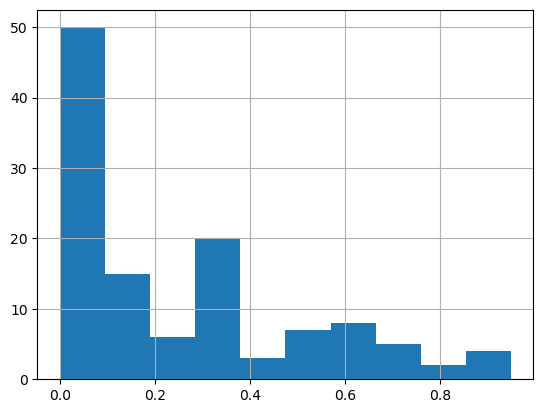

In [72]:
# calculate the proportion of missingness
num_missing = train.isnull().sum()
num_missing =  num_missing/len(train)

num_missing.hist()

**Determine which features to keep in our model**

We can see that there are many variables that are largely incomplete. For our purposes, let's first only keep those variables which have <= 25% missing

In [73]:
vars_low_missing_rate = num_missing[num_missing <= 0.25].index.tolist()

len(vars_low_missing_rate)

71

Using the list of columns with a low missing rate, we can subset our `train` data to only include these columns 

In [74]:
# keep columns with a low missing rate
X_vars = train[vars_low_missing_rate]

X_vars.head()

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Weight,CCU,CSRU,SICU,GCS_first,Glucose_first,HR_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,GCS_last,Glucose_last,HR_last,NIDiasABP_last,NIMAP_last,NISysABP_last,Temp_last,GCS_lowest,Glucose_lowest,HR_lowest,NIDiasABP_lowest,NIMAP_lowest,NISysABP_lowest,Temp_lowest,GCS_highest,Glucose_highest,HR_highest,NIDiasABP_highest,NIMAP_highest,NISysABP_highest,Temp_highest,GCS_median,Glucose_median,HR_median,NIDiasABP_median,NIMAP_median,NISysABP_median,Temp_median,BUN_first,Creatinine_first,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first,BUN_last,Creatinine_last,HCO3_last,HCT_last,K_last,Mg_last,Na_last,PaCO2_last,PaO2_last,Platelets_last,WBC_last,pH_last
0,132539,6,1,5,-1,0,54.0,0.0,NaN,0,0,1,15.0,205.0,73.0,65.0,92.33,147.0,35.1,15.0,115.0,86.0,55.0,79.33,128.0,37.8,14.0,115.0,58.0,39.0,58.67,96.0,35.1,15.0,205.0,86.0,67.0,92.33,157.0,38.2,15.0,160.0,73.0,49.0,70.000,110.0,37.70,13.0,0.8,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN,8.0,0.7,28.0,30.3,4.0,1.9,136.0,NaN,NaN,185.0,9.4,NaN
1,132540,16,8,8,-1,0,76.0,1.0,76.0,0,1,0,3.0,105.0,88.0,38.0,49.33,72.0,35.2,15.0,146.0,65.0,49.0,68.33,107.0,37.1,3.0,105.0,65.0,38.0,49.33,72.0,34.5,15.0,146.0,90.0,67.0,88.33,131.0,37.9,15.0,125.5,80.0,59.0,78.165,115.0,37.45,16.0,0.8,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45,21.0,1.3,24.0,29.4,3.5,1.9,135.0,46.0,140.0,135.0,13.3,7.37
2,132541,21,11,19,-1,0,44.0,0.0,56.7,0,0,0,7.0,141.0,100.0,84.0,100.30,133.0,37.8,5.0,143.0,71.0,84.0,103.00,141.0,37.2,5.0,119.0,57.0,66.0,83.33,111.0,36.7,8.0,143.0,113.0,95.0,110.00,150.0,39.0,5.0,141.0,85.5,79.0,97.670,134.0,37.85,8.0,0.4,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51,3.0,0.3,25.0,29.4,3.7,1.7,138.0,37.0,173.0,113.0,6.2,7.47
3,132543,7,1,9,575,0,68.0,1.0,84.6,0,0,0,15.0,129.0,79.0,63.0,86.67,134.0,36.3,15.0,117.0,79.0,81.0,98.67,134.0,37.0,14.0,106.0,57.0,45.0,68.33,102.0,35.1,15.0,129.0,88.0,81.0,100.70,140.0,37.0,15.0,117.0,74.0,64.0,83.670,120.0,36.40,23.0,0.9,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN,10.0,0.7,28.0,36.3,3.8,1.9,137.0,NaN,NaN,284.0,7.9,NaN
4,132545,17,2,4,918,0,88.0,0.0,NaN,0,0,0,15.0,113.0,93.0,41.0,75.33,144.0,37.8,15.0,92.0,68.0,42.0,73.00,135.0,36.7,15.0,92.0,65.0,26.0,52.33,105.0,35.8,15.0,113.0,94.0,96.0,105.70,157.0,37.8,15.0,102.5,73.0,42.0,75.330,131.0,37.00,45.0,1.0,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN,25.0,1.0,20.0,30.9,4.1,1.6,139.0,NaN,NaN,97.0,4.8,NaN


We can further reduce the number of variables by only choosing the first lab or vital measurements

In [75]:
X_first = X_vars.filter(regex='_first$')# keeps columns with the word 'first'
X_first.columns

Index(['GCS_first', 'Glucose_first', 'HR_first', 'NIDiasABP_first',
       'NIMAP_first', 'NISysABP_first', 'Temp_first', 'BUN_first',
       'Creatinine_first', 'HCO3_first', 'HCT_first', 'K_first', 'Mg_first',
       'Na_first', 'PaCO2_first', 'PaO2_first', 'Platelets_first', 'WBC_first',
       'pH_first'],
      dtype='object')

We should also consider keeping demographic (`Age`, `Gender`) and baseline information like `Weight` or intensive care unit admitted (`CCU`, `CSRU`, `SICU`) 

In [76]:
X_baseline = X_vars[['Age', 'Gender', 'Weight', 'CCU', 'CSRU', 'SICU']]

Combine maintained set of features

In [77]:
X_train = pd.merge(X_baseline, 
                   X_first,
                   left_index=True, 
                   right_index=True)

In [78]:
X_train.head()

,Age,Gender,Weight,CCU,CSRU,SICU,GCS_first,Glucose_first,HR_first,NIDiasABP_first,NIMAP_first,NISysABP_first,Temp_first,BUN_first,Creatinine_first,HCO3_first,HCT_first,K_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,WBC_first,pH_first
0,54.0,0.0,NaN,0,0,1,15.0,205.0,73.0,65.0,92.33,147.0,35.1,13.0,0.8,26.0,33.7,4.4,1.5,137.0,NaN,NaN,221.0,11.2,NaN
1,76.0,1.0,76.0,0,1,0,3.0,105.0,88.0,38.0,49.33,72.0,35.2,16.0,0.8,21.0,24.7,4.3,3.1,139.0,34.0,344.0,164.0,7.4,7.45
2,44.0,0.0,56.7,0,0,0,7.0,141.0,100.0,84.0,100.30,133.0,37.8,8.0,0.4,24.0,28.5,3.3,1.9,137.0,37.0,65.0,72.0,4.2,7.51
3,68.0,1.0,84.6,0,0,0,15.0,129.0,79.0,63.0,86.67,134.0,36.3,23.0,0.9,28.0,41.3,4.0,2.1,140.0,NaN,NaN,391.0,11.5,NaN
4,88.0,0.0,NaN,0,0,0,15.0,113.0,93.0,41.0,75.33,144.0,37.8,45.0,1.0,18.0,22.6,6.0,1.5,140.0,NaN,NaN,109.0,3.8,NaN


Review number of missing variables once more on the 'cleaner' dataset

In [79]:
X_train.isnull().sum().sort_values()

Age                   0
CCU                   0
SICU                  0
CSRU                  0
Gender                3
HR_first             63
Creatinine_first     64
GCS_first            64
BUN_first            64
Temp_first           64
HCT_first            64
Platelets_first      68
Na_first             75
HCO3_first           76
WBC_first            92
K_first              96
Mg_first            103
Glucose_first       113
Weight              331
NISysABP_first      515
NIDiasABP_first     518
NIMAP_first         520
pH_first            962
PaO2_first          977
PaCO2_first         977
dtype: int64

In [80]:
# we will drop the 3 patients without a gender
X_train = X_train.dropna(subset=['Gender'])

Create `y` dataframe that will only contain our outcome of interest (`in-hospital_death`):

- When `in-hospital_death`=1 - indicates the patient died in the hospital
- When `in-hospital_death`=0 - indicates the patient did not die in the hospital

In [81]:
# this step takes our `in-hospital_death` column from the original `train` data and combines it with the cleaned up X_train dataframe
# this allows us to remove the 3 patients that we dropped who were missing gender
y = pd.merge(train['In-hospital_death'], X_train,
             left_index=True, 
             right_index=True)

# select outcome of interest
y = y['In-hospital_death']

# rename y df
y_train = y.copy()

y_train

0       0
1       0
2       0
3       0
4       0
       ..
3995    0
3996    0
3997    0
3998    1
3999    0
Name: In-hospital_death, Length: 3997, dtype: int64

Tally the number of patients meeting each outcome

In [82]:
y_train.value_counts()

In-hospital_death
0    3444
1     553
Name: count, dtype: int64

### **Training a [Lasso Logistic Regression](https://scikit-learn.org/dev/modules/linear_model.html#binary-case) Model**

Now that are data is clean and we have `X_train` and `y_train` dataframes, we can be start getting ready to train models.

We will focus on training a Lasso Logistic regression classifier to predict hospital survival or death.

**Lasso** = Least Absolute Shrinkage and Selection Operator 

<img src="lecture_images/logistic_regression.png" alt="title" width="400" align="left">

[Image Source](https://www.javatpoint.com/logistic-regression-in-machine-learning)

In logistic regression, we are trying to predict the probability of $y=1$ given a set of features $X$. 

In our case, $y$ represents `in-hospital_death`. 

Thus, `in-hospital__death` = 1 is equivalent to $y=1$ that the patient died in the hospital

For each data point $i$ (or each patient observation):

$P(y_i=1|X_i)$

In other words, logistic regression allows us to predict the probability that a patient has our outcome of interest (`in-hospital_death`=1) **given** the specific set of $X$ features of that patient.

**Other Notes**:

* Logistic Regeression is used for classification, thus need a binary outcome variable (e.g. survival or death)
* Good baseline model (simple!)
* L1 (Lasso) vs L2 (Ridge) regularization - a penalty to avoid overfitting - essentially, shrinking the coefficients of non-informative variables
* [scikit-learn documentation](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html#logisticregression) shows us which parameters we can set when constructing a logistic regression model. 

### **Setting up a Machine Learning Pipeline**

Before, we can start training our model, there are some additional machine learning pre-processing steps we have to take. 

Fortuntately, scikit-learn has a lot of useful functions - such as `Pipeline()` - to help streamline this process. 

The code below sets up the pipeline. Essentially, we want our pipeline to do the following:

1. Impute any missing values (via the median)
2. Standardize numeric variables (mean 0 and standard deviation of 1)

In [83]:
# specify numeric features to standardize and impute 
numeric_features = ['Age', 'Weight', 'GCS_first', 'Glucose_first', 'HR_first', 'NIDiasABP_first', 'NIMAP_first',
                    'NISysABP_first', 'Temp_first', 'BUN_first', 'Creatinine_first', 'HCO3_first', 'HCT_first', 'K_first', 
                    'Mg_first', 'Na_first', 'PaCO2_first', 'PaO2_first', 'Platelets_first', 'WBC_first', 'pH_first']

# specify non-numeric features
non_numeric_features = ['Gender', 'CCU', 'CSRU', 'SICU']

# construct pipeline for preprocessing data 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

non_numeric_transformer = 'passthrough'  # Pass non-numeric features unchanged

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('non_num', non_numeric_transformer, non_numeric_features)
    ]
)

# Initialize lasso (penalty = 'l1') logistic regression model
# class_weight = 'balanced' since the classes of our model (death vs no death) is heavily imbalanced
lr = LogisticRegression(solver='liblinear', random_state = 12345, penalty = 'l1', class_weight = 'balanced')

# Create a pipeline with preprocessing and a model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lr)  # Replace with your model of choice
])

These pipeline steps make it possible to prepare our data for model training and tuning. 

#### What is model tuning?

Machine learning models have different types of hyperparamters which can be changed to try and optimize model performance. 

We won't discuss too much here, but essentially, we often are training a model to minimize an objective function (also referred to as a loss or cost function depending on the context). 

Tuning these parameters is what can help minimize the model's objective function and improve classification performance.

Additionally, tuning is often performed using **cross-fold validation**. A technique where a dataset is divived into $k$ folds (usually k=5 or k=10). 

Thus, if $k=5$, we randomly divide the model into 5 equal folds:

<img src="lecture_images/k_fold_cross_validation.png" alt="title" width="400" align="left">

* 4 folds are used for training with different sets of hyperparameters 
* The remaining held-out fold is used how the model does on data it hasn't seen before
* This process is repeated until each fold is used as the held-out test set once
* The optimal hyperparaters are chosen based on the average performance across folds 

#### How do we choose and evaluate the different hyperparameters?

In this demonstration, we will evaluate hyperparameters using the scikit-learn function `GridSearch` - this allows us to pre-specify all of the specific hyperparameters we want to evaluate in a grid.

 During Cross-fold validation, we test all possible hyperparameter combinations in this grid to determine those which provide the best performance across folds

### Cross-validation and GridSearch

Let's set up `GridSearchCV` framework to train and tune our model with 5-fold Cross Validation

In [84]:
# Define parameter grid for model tuning
param_grid = {
    'classifier__tol': [1e-5, 1e-4, 1e-3], # model training stops once the optimization convergence criteria falls below a certain threshold
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]   # Range of regularization strengths (inverse of regularization strength)
}

# Set up GridSearchCV
lr_grid_search = GridSearchCV(estimator=model_pipeline, # specific our pipeline as our estimator 
                              param_grid=param_grid, # specify the hyperparameter parameter grid
                              cv=5, # how many folds to evaluate with cross-fold validation
                              scoring='roc_auc', # this specifies that we are going to use the AUC as a metric to evaluate how well our model does across folds
                              return_train_score=True) # whether to return the training scores

Now that we've specified our pipeline and implemented it into our gridsearch/cross validation, we can train (or fit!) our model to our training data. The code will automatically create our folds for us!

In [85]:
# Fit the random search object to the data
fit_lr_grid_search = lr_grid_search.fit(X_train, y_train)
fit_lr_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Weight',
                                                                          'GCS_first',
                                                                          'Glucose_first',
                                                                          'HR_first',
                                                                          'NIDiasABP_first',
                                                                          'NIMAP_first',
                                                                          'NISysABP_first',
                                                                          'Temp_first',
                                                                          'BUN_first',
                                                                          'Creatinine_first',
                                                                          'HCO3_first'...
                                                                          'Platelets_first',
                                                                          'WBC_first',
                                                                          'pH_first']),
                                                                        ('non_num',
                                                                         'passthrough',
                                                                         ['Gender',
                                                                          'CCU',
                                                                          'CSRU',
                                                                          'SICU'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           penalty='l1',
                                                           random_state=12345,
                                                           solver='liblinear'))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__tol': [1e-05, 0.0001, 0.001]},
             return_train_score=True, scoring='roc_auc')

#### So what is going on when we fit this model?

Our pipeline ensures the following:

1. Our data is divided into 5-folds
2. We train the model on 4-folds
3. These 4-folds are pre-processed (numeric data standardized and imputed as needed)
4. GridSearch tests each combination of hyperparamters (e.g., `tol=1e-4` and `C=0.001`; `tol=1e-4` and `C=0.01` *[....] and so forth across the specified grid*)
5. For each set of training folds and combination of hyperparameters, we evaluate performance (AUC) on the held-out fold
6. This process repeats until all 5-folds and hyperparameter combos have been evaluted
7. The set of hyperparameters with the highest average *AUC will be chosen as our best model 

*We'll discuss more, but the AUC (Area Under the Curve) refers to the area under the Receiver Operating Characteristic (ROC) curve. This metric quantifies the average classification performance of a model (ranging from 0 to 1) by evaluating its ability to distinguish between true positives and false positives across various thresholds.

#### **Concept Check:** 

Why do we perform the pre-processing step on 4-folds at a time? Can we standardize and impute all of the data prior to starting the training/tuning steps? Why or why not?

### Model Evaluation on Training set

We can determine what the best hyperparameters and the average AUC is from the fitted object `fit_lr_grid_search`:

In [86]:
# Best parameters and score
print(f"Best performing hyperparameters: {fit_lr_grid_search.best_params_}")
print(f"Average AUC: {fit_lr_grid_search.best_score_.round(4)}")

Best performing hyperparameters: {'classifier__C': 1, 'classifier__tol': 0.001}
Average AUC: 0.7388


We can also see the results from all of the models evaluated during the tuning process

In [87]:
# Access the cv_results_ dictionary
cv_results = fit_lr_grid_search.cv_results_

# Create a DataFrame from cv_results_
results_df = pd.DataFrame(cv_results)

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.015744,0.002281,0.004711,0.000561,0.001,0.00001,"{'classifier__C': 0.001, 'classifier__tol': 1e...",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,16,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
1,0.014128,0.000950,0.004585,0.000646,0.001,0.00010,"{'classifier__C': 0.001, 'classifier__tol': 0....",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,16,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
2,0.018422,0.004155,0.006555,0.001995,0.001,0.00100,"{'classifier__C': 0.001, 'classifier__tol': 0....",0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,16,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000
3,0.014009,0.000462,0.003830,0.000119,0.010,0.00001,"{'classifier__C': 0.01, 'classifier__tol': 1e-05}",0.724160,0.770957,0.707653,0.668083,0.674667,0.709104,0.037211,13,0.723917,0.712969,0.725333,0.719736,0.734565,0.723304,0.007083
4,0.015100,0.001532,0.004223,0.000592,0.010,0.00010,"{'classifier__C': 0.01, 'classifier__tol': 0.0...",0.724160,0.770957,0.707640,0.668083,0.674667,0.709101,0.037211,14,0.723913,0.712969,0.725332,0.719735,0.734565,0.723303,0.007083
5,0.013665,0.000553,0.004021,0.000463,0.010,0.00100,"{'classifier__C': 0.01, 'classifier__tol': 0.001}",0.724160,0.770944,0.707600,0.668083,0.674628,0.709083,0.037214,15,0.723908,0.712976,0.725331,0.719734,0.734574,0.723305,0.007084
6,0.021751,0.003328,0.004551,0.001044,0.100,0.00001,"{'classifier__C': 0.1, 'classifier__tol': 1e-05}",0.739641,0.777521,0.730175,0.743660,0.701406,0.738481,0.024478,11,0.754453,0.745228,0.756436,0.750137,0.764688,0.754189,0.006512
7,0.020036,0.001942,0.005058,0.000808,0.100,0.00010,"{'classifier__C': 0.1, 'classifier__tol': 0.0001}",0.739641,0.777521,0.730189,0.743660,0.701367,0.738475,0.024489,12,0.754454,0.745226,0.756437,0.750136,0.764687,0.754188,0.006513
8,0.017170,0.001602,0.004493,0.000576,0.100,0.00100,"{'classifier__C': 0.1, 'classifier__tol': 0.001}",0.739667,0.777534,0.730228,0.743660,0.701341,0.738486,0.024498,10,0.754462,0.745207,0.756420,0.750135,0.764676,0.754180,0.006513
9,0.050443,0.001875,0.005762,0.001275,1.000,0.00001,"{'classifier__C': 1, 'classifier__tol': 1e-05}",0.735875,0.774932,0.725294,0.754440,0.703515,0.738811,0.024438,2,0.757279,0.748484,0.759709,0.751647,0.766390,0.756702,0.006266


Let's just look at the best performing model (based on AUC)

In [88]:
# Extract the row corresponding to the best index
best_row_df = results_df.loc[[fit_lr_grid_search.best_index_]]  # Use double brackets to keep it as a DataFrame
best_row_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__C,param_classifier__tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
11,0.037155,0.008572,0.005531,0.000977,1.0,0.001,"{'classifier__C': 1, 'classifier__tol': 0.001}",0.735888,0.774932,0.725518,0.754374,0.703462,0.738835,0.02442,1,0.757285,0.748491,0.759731,0.751645,0.766384,0.756707,0.006265


## Training Evaluation

There are many ways to evaluate the performance of our training. The below modules will review a few!

### Model Coefficients (important predictors)

Default coefficients are represented as log-odds

We can exponentiate the log-odds to get the odds ratio:

$\text{Odds Ratio} = e^{\text{coef}}$

**To intepret:**
* A feature with an odds ratio > 1 - are features in which the odds of death increase when that feature increases
* A feature with an odds ratio < 1 - are features in which the odds of death decrease when that feature increases
* A feature with an odds ratio = 1 - are features which have no effect on the outcome (death)



In [89]:
# Access the best estimator
best_lasso = lr_grid_search.best_estimator_

# Extract coefficients from the Lasso model
lasso_coefficients = best_lasso.named_steps['classifier'].coef_.flatten().tolist()

# If needed, map coefficients to feature names
feature_names = X_train.columns.tolist()  # Replace with your list of feature names
coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_coefficients
})

coefficients_df['abs(coef)'] = coefficients_df['Coefficient'].abs()
coefficients_df['Odds Ratio'] = np.exp(coefficients_df['Coefficient'])

# Display the coefficients
coefficients_df.sort_values(by='Odds Ratio', ascending=True).reset_index(drop=True).head(10)

,Feature,Coefficient,abs(coef),Odds Ratio
0,WBC_first,-1.561197,1.561197,0.209885
1,Platelets_first,-0.452355,0.452355,0.636128
2,Weight,-0.370489,0.370489,0.690397
3,SICU,-0.369363,0.369363,0.691174
4,Glucose_first,-0.258278,0.258278,0.772380
5,HCT_first,-0.208594,0.208594,0.811725
6,PaCO2_first,-0.204994,0.204994,0.814652
7,K_first,-0.172407,0.172407,0.841636
8,HCO3_first,-0.150314,0.150314,0.860438
9,Mg_first,-0.149042,0.149042,0.861533


### Confusion Matrix

A confusion matrix helps us calculate our true and false positive rates. This in turn, helps us calculate important metrics such as: 

* sensitivity - TP / (TP + FN)
* specificity - TN / (TN + FP) 
* positive predictive value (precision) - TP / (TP + FP)
* negative predictive value - TN / (TN + FN)

classification report:
                precision    recall  f1-score   support

           0      0.935     0.681     0.788      3444
           1      0.262     0.705     0.382       553

    accuracy                          0.685      3997
   macro avg      0.599     0.693     0.585      3997
weighted avg      0.842     0.685     0.732      3997

confusion matrix:
 


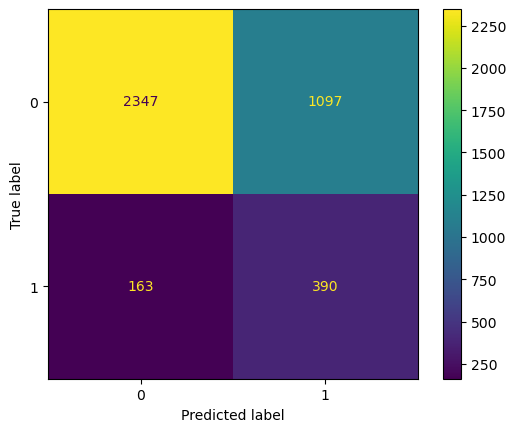

In [90]:
# predicted classes using default 0.5 threshold
y_hat = fit_lr_grid_search.predict(X_train) 

print("classification report:\n ", classification_report(y_train, y_hat, digits=3))
print("confusion matrix:\n ")

# Create the confusion matrix
cm = confusion_matrix(y_train, y_hat)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

### Receiver Operating Characteristic Curve

A ROC plots the true positive rate (sensitivity) vs false positive rate (1-specificity) at different decision thresholds. This allows us to calculate the area under the curve (AUC) to estimate model performance. An AUC of 0.5 indicates a model that performs as well as a coin flip (50/50).

The use of the `GridSearchCV()` function, automatically refits the best trained/tuned model using all of our data.

Thus, we can use the fitted object to evaluate some performance metrics

In [91]:
# calculate the predicted probabilities on all of the training data
y_proba = fit_lr_grid_search.predict_proba(X_train)[:,1] 

# calculate the area under the curve (AUC)
auc = roc_auc_score(y_train, y_proba)

Text(0.5, 0, 'False Positive Rate')

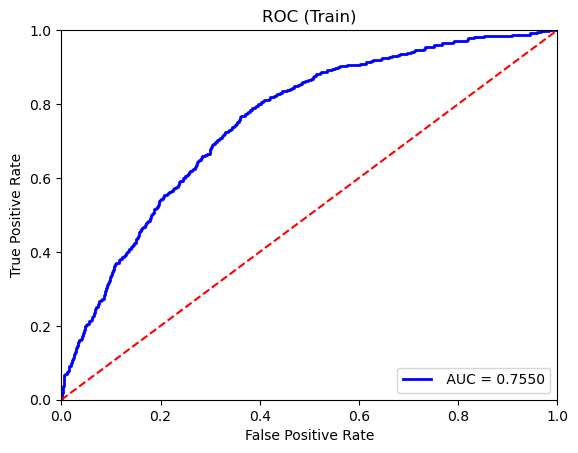

In [92]:
# calculate false positive rate and the true positive rate in order to construct a receiver operating curve (ROC)
fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)

plt.title('ROC (Train)')
ax1 = plt.plot(fpr, tpr, 'b', label = '%s AUC = %0.4f' % ('', auc), linewidth=2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### Precision-Recall Curve

The curve plots the prcesion and recall at different decision thresholds. Recall or the true positive rate tells us how well the model correctly identifies all positive cases, whereas precision estimates the proportion of cases the model identified as positive that were truely positive.

Text(0.5, 0, 'Recall')

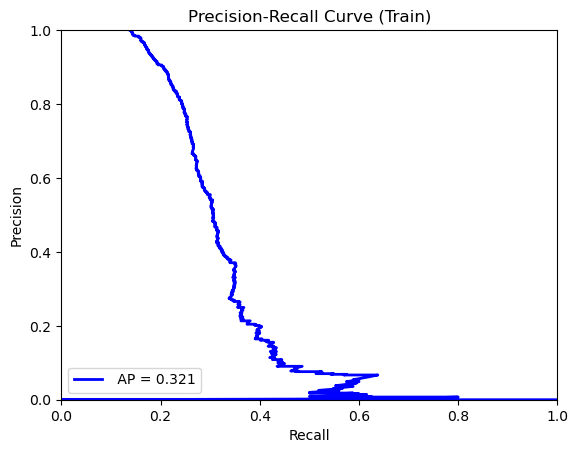

In [93]:
y_proba = fit_lr_grid_search.predict_proba(X_train)[:,1]

precision, recall, thresholds = precision_recall_curve(y_train, y_proba, pos_label=1, sample_weight=None)
avg_p = average_precision_score(y_train, y_proba, pos_label=1, sample_weight=None)

plt.title('Precision-Recall Curve (Train)')
ax1= plt.plot(precision, recall, 'b', label = '%s AP = %0.3f' % ('', avg_p), linewidth=2)
plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')

## Evaluation on Held-out Test Set

Let's see how well our trained model does on data it has never seen before

In [94]:
test = pd.read_csv('../challenge2012/data/PhysionetChallenge2012-set-b.csv')
test

,recordid,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,GCS_first,Glucose_first,HR_first,MAP_first,NIDiasABP_first,NIMAP_first,NISysABP_first,RespRate_first,SaO2_first,Temp_first,DiasABP_last,GCS_last,Glucose_last,HR_last,MAP_last,NIDiasABP_last,NIMAP_last,NISysABP_last,RespRate_last,SaO2_last,Temp_last,DiasABP_lowest,GCS_lowest,Glucose_lowest,HR_lowest,MAP_lowest,NIDiasABP_lowest,NIMAP_lowest,NISysABP_lowest,RespRate_lowest,SaO2_lowest,Temp_lowest,DiasABP_highest,GCS_highest,Glucose_highest,HR_highest,MAP_highest,NIDiasABP_highest,NIMAP_highest,NISysABP_highest,RespRate_highest,SaO2_highest,Temp_highest,DiasABP_median,GCS_median,Glucose_median,HR_median,MAP_median,NIDiasABP_median,NIMAP_median,NISysABP_median,RespRate_median,SaO2_median,Temp_median,ALP_first,ALT_first,AST_first,Albumin_first,BUN_first,Bilirubin_first,Cholesterol_first,Creatinine_first,FiO2_first,HCO3_first,HCT_first,K_first,Lactate_first,Mg_first,Na_first,PaCO2_first,PaO2_first,Platelets_first,SysABP_first,TroponinI_first,TroponinT_first,WBC_first,Weight_first,pH_first,ALP_last,ALT_last,AST_last,Albumin_last,BUN_last,Bilirubin_last,Cholesterol_last,Creatinine_last,FiO2_last,HCO3_last,HCT_last,K_last,Lactate_last,Mg_last,Na_last,PaCO2_last,PaO2_last,Platelets_last,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,142675,27,14,9,7,1,70.0,1.0,175.3,85.00,0,1,0,60.0,3.0,194.0,76.0,76.0,NaN,NaN,NaN,NaN,98.0,35.7,43.0,3.0,125.0,22.0,61.0,NaN,NaN,NaN,NaN,98.0,37.6,40.0,3.0,125.0,10.0,41.0,NaN,NaN,NaN,NaN,87.0,33.4,98.0,3.0,194.0,95.0,108.0,NaN,NaN,NaN,NaN,98.0,37.8,56.0,3.0,159.5,62.0,72.0,NaN,NaN,NaN,NaN,98.0,36.65,24.0,45.0,106.0,1.7,13.0,0.9,NaN,0.8,1.0,22.0,33.7,4.3,14.4,21.0,142.0,32.0,378.0,185.0,104.0,NaN,NaN,7.9,NaN,7.50,23.0,137.0,1106.0,2.0,24.0,2.8,NaN,2.1,1.00,23.0,29.5,4.4,3.9,1.3,147.0,37.0,117.0,41.0,105.0,NaN,NaN,6.1,NaN,7.38,99.0,2559.0,1.0,13.0
1,142676,12,1,31,468,0,57.0,0.0,NaN,NaN,0,0,0,NaN,15.0,229.0,86.0,NaN,51.0,77.33,130.0,22.0,NaN,35.3,NaN,15.0,198.0,92.0,NaN,77.0,100.70,148.0,14.0,NaN,37.6,NaN,14.0,79.0,72.0,NaN,37.0,63.00,110.0,11.0,NaN,35.3,NaN,15.0,273.0,109.0,NaN,79.0,100.70,148.0,30.0,NaN,37.9,NaN,15.0,192.5,89.0,NaN,53.0,81.670,130.0,17.0,NaN,36.70,NaN,NaN,NaN,NaN,35.0,NaN,NaN,0.7,NaN,7.0,43.8,3.1,NaN,2.0,148.0,NaN,NaN,616.0,NaN,NaN,NaN,22.4,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,0.4,NaN,21.0,32.5,3.2,NaN,1.8,134.0,NaN,NaN,517.0,NaN,NaN,NaN,15.1,NaN,NaN,NaN,NaN,NaN,NaN
2,142680,12,7,17,16,1,60.0,1.0,182.9,78.80,0,0,0,49.0,9.0,127.0,90.0,61.0,74.0,89.33,120.0,NaN,93.0,38.0,55.0,7.0,135.0,98.0,70.0,55.0,74.33,113.0,NaN,93.0,38.4,45.0,7.0,127.0,53.0,61.0,41.0,58.00,90.0,NaN,93.0,36.2,92.0,10.0,153.0,115.0,246.0,74.0,95.33,148.0,NaN,93.0,39.7,56.5,8.0,135.0,87.0,70.0,56.0,75.665,113.5,NaN,93.0,38.00,77.0,44.0,26.0,NaN,21.0,0.7,NaN,0.8,0.5,30.0,38.8,4.3,NaN,1.9,138.0,65.0,71.0,233.0,91.0,NaN,NaN,14.5,79.4,7.33,77.0,53.0,29.0,NaN,23.0,0.7,NaN,0.7,0.70,31.0,37.7,3.5,NaN,1.8,136.0,53.0,76.0,207.0,104.0,NaN,NaN,17.6,79.5,7.45,207.0,2570.0,1.0,20.0
3,142683,19,15,17,-1,0,64.0,1.0,180.3,145.20,0,1,0,76.0,3.0,191.0,87.0,75.0,NaN,NaN,NaN,NaN,95.0,37.4,59.0,3.0,166.0,68.0,84.0,NaN,NaN,NaN,NaN,97.0,37.0,40.0,3.0,166.0,62.0,29.0,NaN,NaN,NaN,NaN,89.0,36.6,90.0,3.0,191.0,87.0,113.0,NaN,NaN,NaN,NaN,97.0,38.0,58.0,3.0,178.5,74.0,77.0,NaN,NaN,NaN,NaN,92.5,37.20,39.0,160.0,186.0,1.6,11.0,0.7,NaN,0.9,1.0,18.0,33.9,4.9,1.8,1.6,138.0,45.0,294.0,104.0,137.0,NaN,NaN,18.3,NaN,7.33,49.0,1593.0,1933.0,3.0,19.0,1.8,NaN,1.4,0.65,24.0,28.3,5.0,4.5,2.4,137.0,42.0,107.0,79.0,140.0,NaN,NaN,18.3,NaN,7.36,374.0,2420.0,1.0,14.0
4,142688,3,0,9,-1,0,51.0,1.0,172.7,90.00,0,0,1,55.0,15.0,165.0,91.0,74.0,63.0,76.33,103.0,24.0,NaN,36.8,68.0,14.0,130.0,113.0,81.0,66.0,86.33,127.0,20.0,NaN,38.7,53.0,14.0,130.0,88.0,69.0,50.0,71.00,99.0,13.0,NaN,36.8,74.0,15.0,165.0,115.0,89.0,68.0,86.33,127.0,27.0,NaN,38.7,58.0,15.0,147.5,100.5,74.5

We have to make sure our data is structured simiarly 

In [95]:
X_test = test[['Age', 'Gender', 'Weight', 'CCU', 'CSRU', 'SICU', 'GCS_first',
       'Glucose_first', 'HR_first', 'NIDiasABP_first', 'NIMAP_first',
       'NISysABP_first', 'Temp_first', 'BUN_first', 'Creatinine_first',
       'HCO3_first', 'HCT_first', 'K_first', 'Mg_first', 'Na_first',
       'PaCO2_first', 'PaO2_first', 'Platelets_first', 'WBC_first',
       'pH_first']]

# we will drop the small handful of patients without a gender
X_test = X_test.dropna(subset=['Gender'])

## format the y_test variable
y_test = test.copy()

# merge with the index for train to remove the handful of patients without gender
y_test = pd.merge(y_test['In-hospital_death'], X_test,
                  left_index=True, 
                  right_index=True)

# select only the outcome of interest
y_test = y_test['In-hospital_death']

### Final Test-set Evaluation Metrics

#### Confusion Matrix (Test)

classification report (Test):
                precision    recall  f1-score   support

           0      0.930     0.673     0.781      3427
           1      0.261     0.695     0.379       568

    accuracy                          0.676      3995
   macro avg      0.595     0.684     0.580      3995
weighted avg      0.835     0.676     0.724      3995



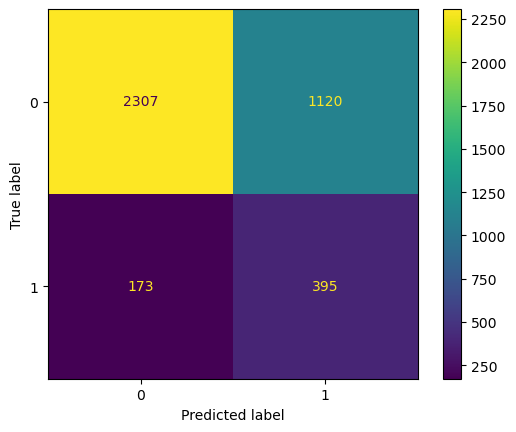

In [96]:
# predicted classes using default 0.5 threshold
y_hat_test = fit_lr_grid_search.predict(X_test) 

print("classification report (Test):\n ", classification_report(y_test, y_hat_test, digits=3))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_hat_test)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

#### Receiver Operating Characteristic Curve (Test)

In [97]:
# calculate the predicted probabilities on all of the training data
y_proba_test = fit_lr_grid_search.predict_proba(X_test)[:,1] 

# calculate the area under the curve (AUC)
auc = roc_auc_score(y_test, y_proba_test)

Text(0.5, 0, 'False Positive Rate')

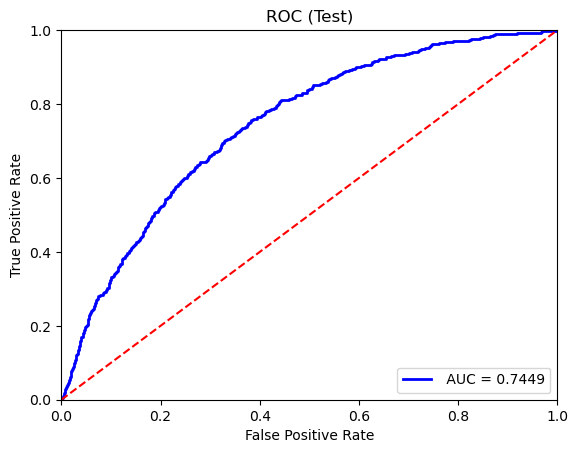

In [98]:
# calculate false positive rate and the true positive rate in order to construct a receiver operating curve (ROC)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_proba_test, pos_label=1)

plt.title('ROC (Test)')
ax1 = plt.plot(fpr_test, tpr_test, 'b', label = '%s AUC = %0.4f' % ('', auc), linewidth=2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#### Precision-Recall Curve (Test)


Text(0.5, 0, 'Recall')

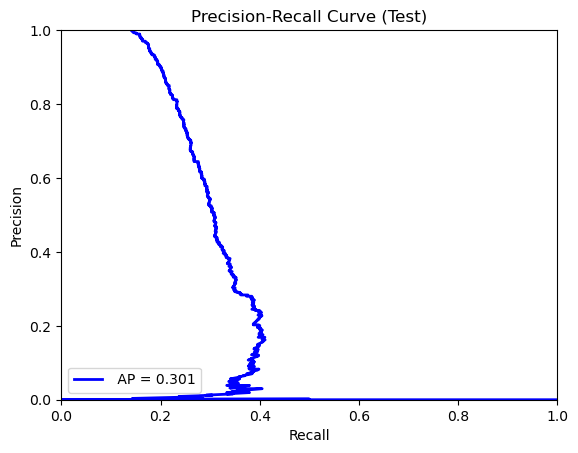

In [99]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba_test, pos_label=1, sample_weight=None)
avg_p_test = average_precision_score(y_test, y_proba_test, pos_label=1, sample_weight=None)

plt.title('Precision-Recall Curve (Test)')
ax1= plt.plot(precision, recall, 'b', label = '%s AP = %0.3f' % ('', avg_p_test), linewidth=2)
plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')

#### **Additional Questions to Consider:**

* Do the most predictive features make clinical sense?

* Which patients is are model classifying incorrectly? - During training, we can look at which patients the model may be predicting wrong. What stands out about the FP or FN patients? Perhaps this could inform our training process.

* What metrics should we prioritize when evaluating this model?

    * In this case, we focused on AUC, but performance metrics are often chosen based on the clinical outcome of interest and the dataset. For example, if our model is trying to classify patients with a criticall ilnness, there may be a high cost to missing a potential diagnosis. We may want to emphasize the sensitivity of our model. On the otherhand, if our model is predicting every patient as a potential diagnosis, healthcare workers might get fatigued from constant false positives.

* How might the following affect model performance:

    * Missing values

    * Class imbalance

* What other types of experiments could we perform with this dataset? Is mortality prediction the best use case? Why or why not?

# An Extra Exercise!

## Random Forest Algorithm

<img src="lecture_images/decision_tree.png" alt="title" width="400" align="left">

* Random forest is an esembling algorithm that learns from generating multiple (hundreds-thousands) of decision trees
* Randomly selects a subset of features when growing each tree 
* This approach allows us to average the predictions of the "crowd"

<b></b>
* Many **hyperparameters** that can be tuned during training of a random forest algorithm:
<br></br>
* `n_estimators`: Number of trees
* `max_features`: Number of featues to be considered at each split 
* `max_depth`: Maximum number of levels in tree (can help regularize the tree to prevent overfitting)
* `min_samples_split`: Minimum samples to split a node 
* `min_samples_leaf`: Minimum number of samples required at each leaf node 

For random forest, we don't need to standardize our features as the tree-based models are able to deal with different feature ranges more intrinsically, thus, we'll need to specify a slightly different pipeline

In [100]:
# construct pipeline for preprocessing data 
numeric_transformer_rf = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    #('scaler', StandardScaler())
])

non_numeric_transformer_rf = 'passthrough'  # Pass non-numeric features unchanged

preprocessor_rf = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_rf, numeric_features),
        ('non_num', non_numeric_transformer_rf, non_numeric_features)
    ]
)

# Create a random forest classifier
rf = RandomForestClassifier(criterion='entropy', random_state=12345, class_weight = 'balanced')

# Create a pipeline with preprocessing and a model
model_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor_rf),
    ('classifier', rf)  # Replace with your model of choice
])

Specify the hyperparameter grid and initiate `GridSearchCV`

In [103]:
### tuning RF hyperparameters
# Number of trees in random forest
n_estimators = [100, 300, 500, 1000]
# Number of features to consider at every split
max_features = [2, 5]
# Maximum number of levels in tree
max_depth = [5, 8]
# Minimum number of samples required to split a node
min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 15]

# create grid of hypterparameter settings
# we will permute through this grid
rf_param_grid = {'classifier__n_estimators': n_estimators,
               'classifier__max_features': max_features,
               'classifier__max_depth': max_depth,
               'classifier__min_samples_split': min_samples_split,
               'classifier__min_samples_leaf': min_samples_leaf}

# Set up GridSearchCV
rf_grid_search = GridSearchCV(estimator=model_pipeline_rf, # specific our pipeline as our estimator 
                              param_grid=rf_param_grid,
                              cv=5,
                              scoring='roc_auc', # this specifies that we are going to use the AUC as a metric to evaluate how well our model does across folds
                              return_train_score=True,
                              refit=True,
                              n_jobs=-1)

Let's train the model!

In [104]:
# Fit the random search object to the data
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Age',
                                                                          'Weight',
                                                                          'GCS_first',
                                                                          'Glucose_first',
                                                                          'HR_first',
                                                                          'NIDiasABP_first',
                                                                          'NIMAP_first',
                                                                          'NISysABP_first',
                                                                          'Temp_first',
                                                                          'BUN_first',
                                                                          'Creatinine_first',
                                                                          'HCO3_first',
                                                                          'HCT_first',
                                                                          'K_first',
                                                                          'Mg_f...
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               criterion='entropy',
                                                               random_state=12345))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5, 8],
                         'classifier__max_features': [2, 5],
                         'classifier__min_samples_leaf': [10, 15],
                         'classifier__min_samples_split': [5, 10],
                         'classifier__n_estimators': [100, 300, 500, 1000]},
             return_train_score=True, scoring='roc_auc')

#### **Your turn! Evaluate the trained model!**

Use this notebook and the previous logistic regression code to determine how to evaluate the trained model. 

Consider changing the training process:

- What happens if you change the parameters in `rf_param_grid`? There are other parameters (as described in the [documentation](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html) you could add. Does this change training performance?
- What happens if we change the number of folds (`cv=k`)? Does the model improve or get worse?
- Try a different scoring metric (`scoring='x'`; see [list of possible metrics'](https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter))